# PairOT Tutorial - Reduce Compute Requirements

This tutorial shows which adjustments one can make to speed up SConnect computations while keeping the method output mostly the same.

This tutorial is based on the original [pairOT tutorial](https://github.com/cellannotation/dataset-similarity/blob/devel/docs/pairOT_tutorial.ipynb).

In [ ]:
# Allow JAX to use all available GPU memory
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.99

In [2]:
from pathlib import Path

import anndata as ad
import pandas as pd
import scanpy as sc
from IPython.display import display, Image

## 0. Required software and data

**Docker containers:**
  * pairOT Docker container: https://hub.docker.com/repository/docker/felix0097/pairOT/general
  * `docker pull felix0097/pairot:full_v1`

**Datasets:**
  * Van der Wijst (Query dataset): https://cellxgene.cziscience.com/collections/7d7cabfd-1d1f-40af-96b7-26a0825a306d
  * Asian Immune Diversity Atlas (Reference dataset): https://celltype.info/project/336/dataset/591/label/71663

**Required Hardware:**
  * We used a Nvidia A40 GPU for this tutorial (48GB VRAM). Less VRAM is fine as well, one will need to reduce the `batch_size` parameter accordingly then.
  * Moreover, for the `Data preparation` section, we recommend around 128GB of system memory

## 1. Data preparation

In [3]:
from pairot.pp import preprocess_adatas

In [4]:
query_dataset = "7d7cabfd-1d1f-40af-96b7-26a0825a306d"
ref_dataset = "ced320a1-29f3-47c1-a735-513c7084d508_CAP"

raw_data_path = Path("/vol/data/dataset-similarity/preprocessed")
preproc_data_path = Path("/vol/data/dataset-similarity/cache")

In [5]:
# Preprocess datasets, this includes:
# 1. Aligning/sort gene space
# 2. Do differential expression testing
# 3. Select highly variable genes
adata_query, adata_ref = preprocess_adatas(
    sc.read_h5ad(raw_data_path / f"{query_dataset}.h5ad"),
    sc.read_h5ad(raw_data_path / f"{ref_dataset}.h5ad"),
    n_top_genes=250,  # use less number of highly variable genes to speed up Spearman correlation computation
    cell_type_column_adata1="cell_type_author",
    cell_type_column_adata2="cell_type_author",
    sample_column_adata1="sample_id",
    sample_column_adata2="sample_id",
    n_samples_auroc=10_000,  # only use 10,000 samples per cluster to speed up AUROC computation
    n_samples_hvg_selection=100_000,  # only use 100,000 cells for HVG selection to reduce memory foot print
)
# Cache preprocessed data
adata_query.write_h5ad(preproc_data_path / f"{query_dataset}_small.h5ad")
adata_ref.write_h5ad(preproc_data_path / f"{ref_dataset}_small.h5ad")

adata1: (600929, 37976)
adata2: (1265624, 38114)
Sub-setting gene space to genes that are expressed in both datasets...
adata1: (600929, 18130)
adata2: (1265624, 18130)
Calculating differentially-expressed genes...


R[write to console]: data.table 1.15.4 using 8 threads (see ?getDTthreads).  
R[write to console]: Latest news: r-datatable.com

Calculating AVA AUROC scores: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 595/595 [19:46<00:00,  1.99s/it]


Sub-setting to highly variable genes...
adata1: (600929, 250)
adata2: (1265624, 250)


**Changes to default settings:**
* `n_top_genes`: Use 250 instead of 750 HVGs for computation of Spearman correlation. This reduces the GPU memory consumption and also speeds up the computation of the optimal transport model
* `n_samples_auroc`: Sub-sample to max 10.000 samples to calculate AUROC scores for each gene. This will drastically, speed up the computation of AUROC scores.
* `n_samples_hvg_selection`: Only use 100.000 genes per dataset to calculate highly variable genes. This will reduce memory consumption.


## 2. Initialize SConnect model

In [5]:
from pairot.pp import downsample_indices

In [6]:
adata_query = ad.read_h5ad(preproc_data_path / f"{query_dataset}_small.h5ad")
adata_ref = ad.read_h5ad(preproc_data_path / f"{ref_dataset}_small.h5ad")
# Make sure that the genes have the same order in both dataset
assert adata_query.var.index.equals(adata_ref.var.index)

In [7]:
# Subsample data before fitting OT model to speed up computation
# To NOT loose rare cell-types, we only sub-sample cell-type clusters with more than n_samples samples
# Those clusters get sub-samples to n_samples
adata_query = adata_query[
    downsample_indices(
        adata_query.obs.cell_type_author.to_numpy(),
        n_samples=10_000,
    ),
    :,
]
adata_ref = adata_ref[
    downsample_indices(
        adata_ref.obs.cell_type_author.to_numpy(),
        n_samples=10_000,
    ),
    :,
]
print(f"adata1: {adata_query.shape}")
print(f"adata2: {adata_ref.shape}")

adata1: (169407, 250)
adata2: (272139, 250)


**Changes to default settings:**
* We subsample the data before fitting the optimal transport model.
* The optimal transport model scales quadratically in the number of samples: `n_samples_query * n_samples_ref`


In [8]:
from pairot.align import DatasetMapping

In [9]:
dataset_map = DatasetMapping(adata_query, adata_ref)

In [10]:
dataset_map.init_geom(
    batch_size=16192,
    epsilon=0.05,
)

**Changes to default settings:**
* `batch_size`
  * We can now increase batch size (if the original data already fitted into memory)
  * If the original data did not fit into memory, we now have a way higher chance that we're able to fit the model now



In [11]:
print(f"x size: {dataset_map.geom.x.shape[0] * dataset_map.geom.x.shape[1] * 4 / 1000**3} GB")
print(f"y size: {dataset_map.geom.y.shape[0] * dataset_map.geom.y.shape[1] * 4 / 1000**3} GB")

x size: 0.170084628 GB
y size: 0.273227556 GB


## 3. Fit SConnect model

In [12]:
dataset_map.init_problem(tau_a=1.0, tau_b=1.0)

In [13]:
dataset_map.solve()

  5%|███████▍                                                                                                                                             | 10/200 [08:23<2:39:30, 50.37s/it, error: 5.184194e-04]


Fitting the SConnect model is significantly faster now. We could reduce the time it takes to fit the model from `~4.5 hours` to less than `10min`.

To summarize how we achived this speedup:
* Only using 250 highly variable genes instead of 750. Hence, speeding up the computation of the Spearman correlation. As has been shown by [Crow et al.](https://www.nature.com/articles/s41467-018-03282-0), this only has very minor effects on the calculated distances. But, significantly reduces computational costs. Moreover, this also reduces the GPU memory consumption.
* Using less cells when fitting the optimal transport model. Again, this leaves the output mostly the same, while considerably reducing computational costs given that the OT model scales quadratically in the number of samples.

## 4. Results of SConnect

We can now compare the results of the downsampled SConnect model to the one that was fitted on the full dataset (see `SConnect_tutorial.ipynb`). As we can see below, the downsampling has little effect on the outputs of SConnect (cluster mapping + cluster distances), while signficantly reducing computational costs.

In [14]:
from pairot.pl import plot_cluster_mapping, plot_cluster_distance

#### OT mappings

In [15]:
cluster_mapping = dataset_map.compute_cluster_mapping(aggregation_method="mean")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:46<00:00,  3.54s/it]


In [ ]:
fig = plot_cluster_mapping(cluster_mapping, sort_by_score=False)
fig.update_layout(title="SConnect mapping using downsampled dataset")
# Interactive plotly plot isn't shown on GitHub
fig

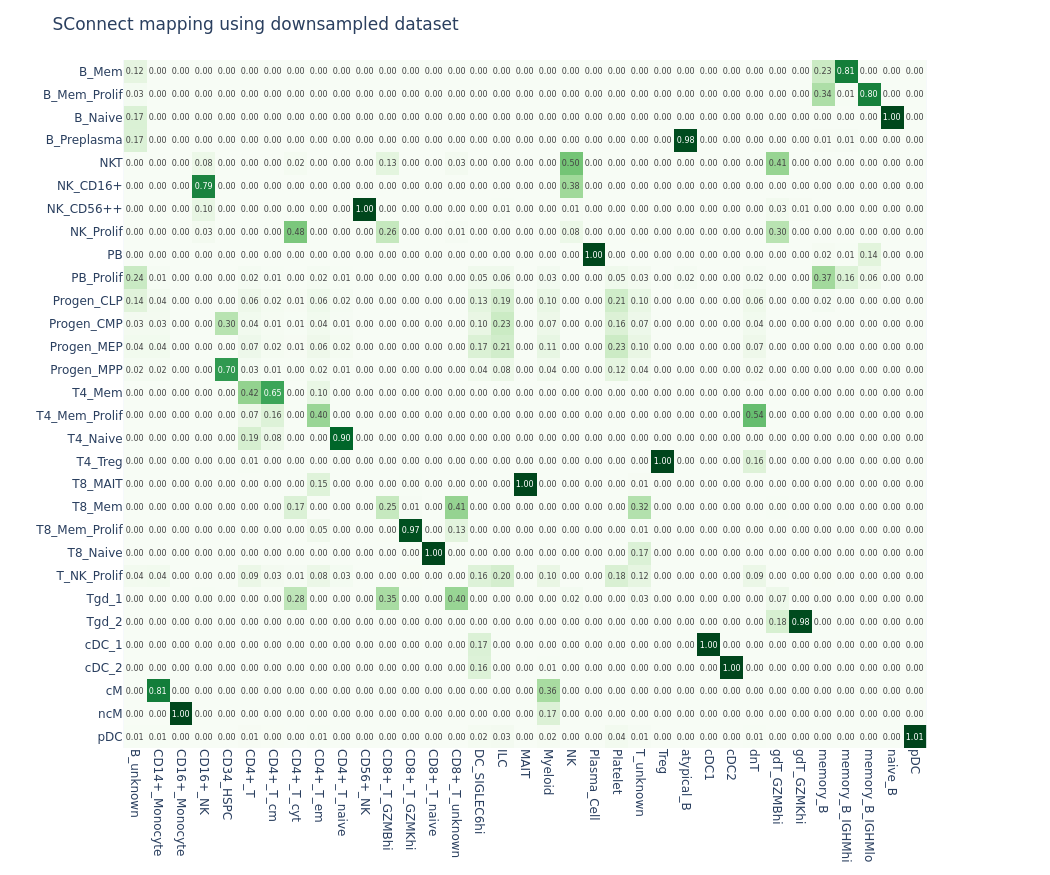

In [17]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_mapping_downsampled.png")
display(Image("cluster_mapping_downsampled.png"))

In [ ]:
cluster_mapping_full = pd.read_parquet("mapping_mean.parquet")

fig = plot_cluster_mapping(cluster_mapping_full, sort_by_score=False)
fig.update_layout(title="SConnect mapping on using dataset (default settings)")
# Interactive plotly plot isn't shown on GitHub
fig

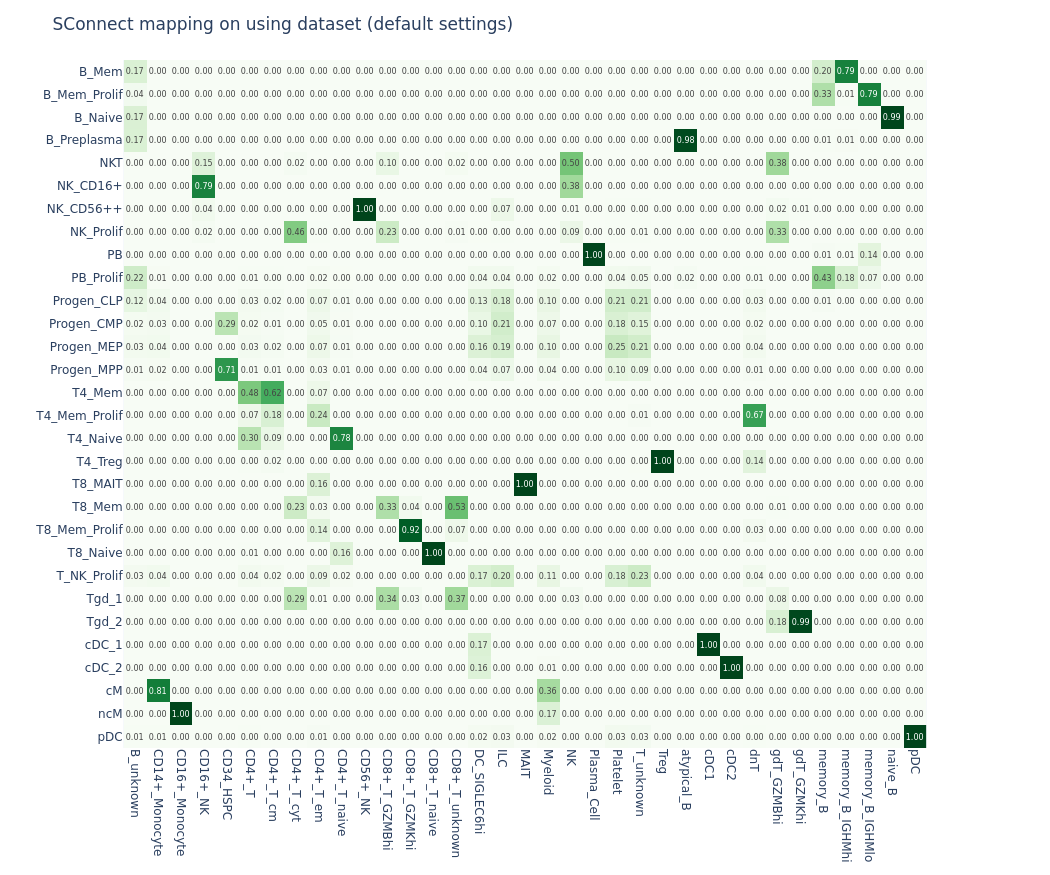

In [19]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_mapping_full.png")
display(Image("cluster_mapping_full.png"))

#### Cluster distance

In [20]:
cluster_distance = dataset_map.compute_cluster_distances()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [04:35<00:00,  3.81it/s]


In [ ]:
# Sort cluster distances by mapping scores as well
fig = plot_cluster_distance(cluster_distance)
fig.update_layout(title="SConnect distance using downsampled dataset")
# Interactive plotly plot isn't shown on GitHub
fig

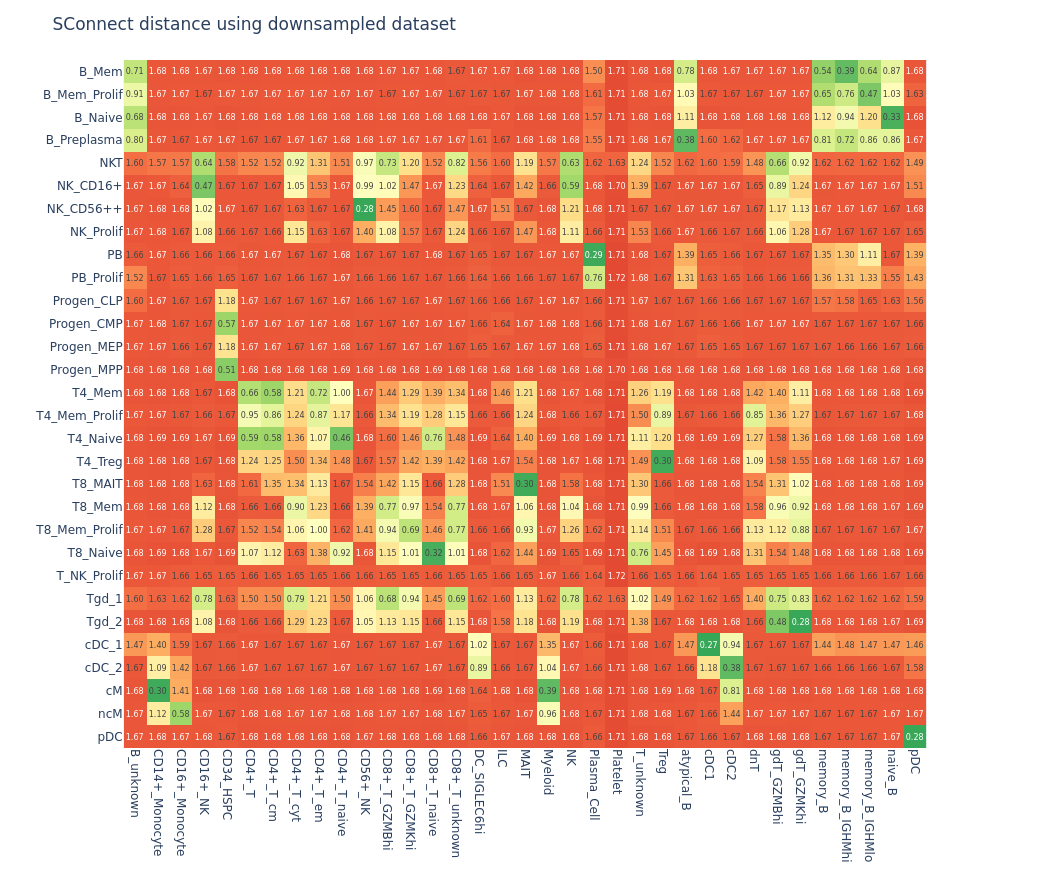

In [22]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_distance_downsampled.png")
display(Image("cluster_distance_downsampled.png"))

In [ ]:
cluster_distance_full = pd.read_parquet("distance.parquet")

fig = plot_cluster_distance(cluster_distance_full)
fig.update_layout(title="SConnect distance using full dataset (default setting)")
# Interactive plotly plot isn't shown on GitHub
fig

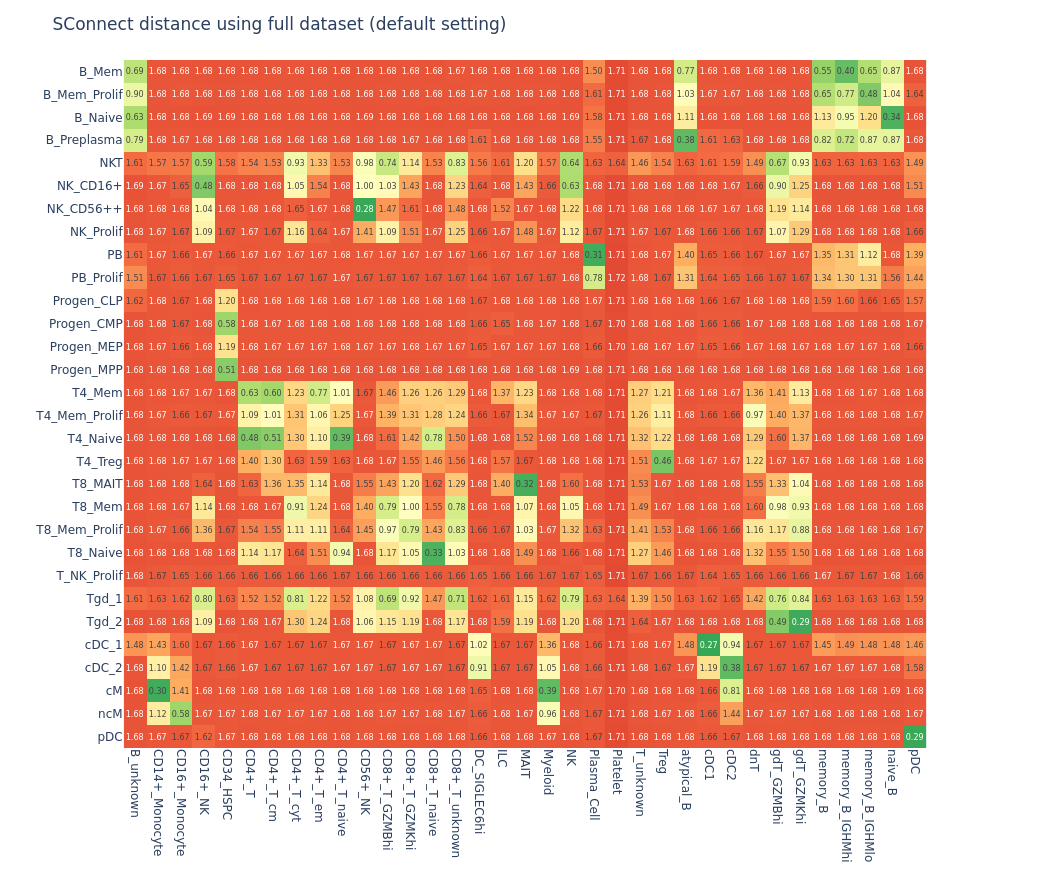

In [24]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_distance_full.png")
display(Image("cluster_distance_full.png"))